In [1]:
from machine_learning.DNN.model import DNN
from machine_learning.DNN.training import train_model
from machine_learning.DNN.data_pipepline import FoodDataset, recipes_data_pipeline

c:\Users\~MatthijsvanGroening\.conda\envs\sdp_food\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# import os
# import pandas as pd
# from seaborn import pairplot

# data_dir = './data'

# data = pd.read_parquet(os.path.join(data_dir, 'cleaned_data.parquet'))
# pairplot(data.iloc[:1000])

In [2]:
import os
from torch.utils.data import DataLoader

data_dir = './data'

train_data = FoodDataset(os.path.join(data_dir, 'cleaned_data.parquet'), train=True)
val_data = FoodDataset(os.path.join(data_dir, 'cleaned_data.parquet'), train=False)

train_data = DataLoader(train_data, batch_size=32, shuffle=True)
val_data = DataLoader(val_data, batch_size=32, shuffle=True)

In [3]:
model = DNN(hidden_layers=5, hidden_dim=128, input_dim=11, output_dim=3)
metrics = train_model(model=model, model_save_dir='./models', 
                      train_dataset=train_data, val_dataset=val_data,
                      lr=0.001, num_epochs=100, l2=1e-5)

val epoch 0: 100%|██████████| 653/653 [00:00<00:00, 680.49it/s, loss=16.2, tp=0, tn=0, fp=0, fn=0]


val epoch 1: 100%|██████████| 653/653 [00:00<00:00, 671.83it/s, loss=16.2, tp=0, tn=0, fp=0, fn=0]


val epoch 2: 100%|██████████| 653/653 [00:00<00:00, 676.76it/s, loss=16.2, tp=0, tn=0, fp=0, fn=0]


val epoch 3: 100%|██████████| 653/653 [00:00<00:00, 657.58it/s, loss=16.2, tp=0, tn=0, fp=0, fn=0]


val epoch 4: 100%|██████████| 653/653 [00:00<00:00, 658.12it/s, loss=16.2, tp=0, tn=0, fp=0, fn=0]


val epoch 5: 100%|██████████| 653/653 [00:01<00:00, 652.02it/s, loss=16.2, tp=0, tn=0, fp=0, fn=0]


val epoch 6: 100%|██████████| 653/653 [00:00<00:00, 660.52it/s, loss=16.2, tp=0, tn=0, fp=0, fn=0]


val epoch 7: 100%|██████████| 653/653 [00:00<00:00, 693.97it/s, loss=16.2, tp=0, tn=0, fp=0, fn=0]


val epoch 8: 100%|██████████| 653/653 [00:00<00:00, 655.93it/s, loss=16.1, tp=0, tn=0, fp=0, fn=0]


val epoch 9: 100%|██████████| 653/653 [00:00<00:00, 692.75it/s, loss=16.1, tp=0, tn=0, fp=0, fn=0]


val epoch 10: 100%|██████████| 653/653 [00:00<00:00, 662.65it/s, loss=16.1, tp=0, tn=0, fp=0, fn=0]


val epoch 11: 100%|██████████| 653/653 [00:00<00:00, 687.78it/s, loss=16.1, tp=0, tn=0, fp=0, fn=0]


val epoch 12: 100%|██████████| 653/653 [00:00<00:00, 656.17it/s, loss=16.1, tp=0, tn=0, fp=0, fn=0]


val epoch 13: 100%|██████████| 653/653 [00:00<00:00, 672.99it/s, loss=16.2, tp=0, tn=0, fp=0, fn=0]


val epoch 14: 100%|██████████| 653/653 [00:00<00:00, 661.61it/s, loss=16.1, tp=0, tn=0, fp=0, fn=0]


val epoch 15: 100%|██████████| 653/653 [00:00<00:00, 687.85it/s, loss=16.1, tp=0, tn=0, fp=0, fn=0]


val epoch 16: 100%|██████████| 653/653 [00:01<00:00, 647.27it/s, loss=16.1, tp=0, tn=0, fp=0, fn=0]


val epoch 17: 100%|██████████| 653/653 [00:01<00:00, 650.62it/s, loss=16.1, tp=0, tn=0, fp=0, fn=0]


val epoch 18: 100%|██████████| 653/653 [00:01<00:00, 587.83it/s, loss=16.1, tp=0, tn=0, fp=0, fn=0]


val epoch 19: 100%|██████████| 653/653 [00:01<00:00, 581.18it/s, loss=16.1, tp=0, tn=0, fp=0, fn=0]


val epoch 20: 100%|██████████| 653/653 [00:01<00:00, 550.95it/s, loss=16.1, tp=0, tn=0, fp=0, fn=0]


val epoch 21: 100%|██████████| 653/653 [00:01<00:00, 614.22it/s, loss=16.1, tp=0, tn=0, fp=0, fn=0]


val epoch 22: 100%|██████████| 653/653 [00:01<00:00, 642.69it/s, loss=16.2, tp=0, tn=0, fp=0, fn=0]


val epoch 23: 100%|██████████| 653/653 [00:01<00:00, 630.99it/s, loss=16.2, tp=0, tn=0, fp=0, fn=0]


val epoch 24: 100%|██████████| 653/653 [00:00<00:00, 684.17it/s, loss=16.1, tp=0, tn=0, fp=0, fn=0]


val epoch 25: 100%|██████████| 653/653 [00:00<00:00, 671.56it/s, loss=16.2, tp=0, tn=0, fp=0, fn=0]


val epoch 26: 100%|██████████| 653/653 [00:01<00:00, 643.23it/s, loss=16.2, tp=0, tn=0, fp=0, fn=0]


val epoch 27: 100%|██████████| 653/653 [00:00<00:00, 688.19it/s, loss=16.2, tp=0, tn=0, fp=0, fn=0]


val epoch 28: 100%|██████████| 653/653 [00:00<00:00, 660.31it/s, loss=16.1, tp=0, tn=0, fp=0, fn=0]


val epoch 29: 100%|██████████| 653/653 [00:00<00:00, 706.18it/s, loss=16.2, tp=0, tn=0, fp=0, fn=0]


val epoch 30: 100%|██████████| 653/653 [00:00<00:00, 704.55it/s, loss=16.1, tp=0, tn=0, fp=0, fn=0]


 
Early stopping after 30 epochs


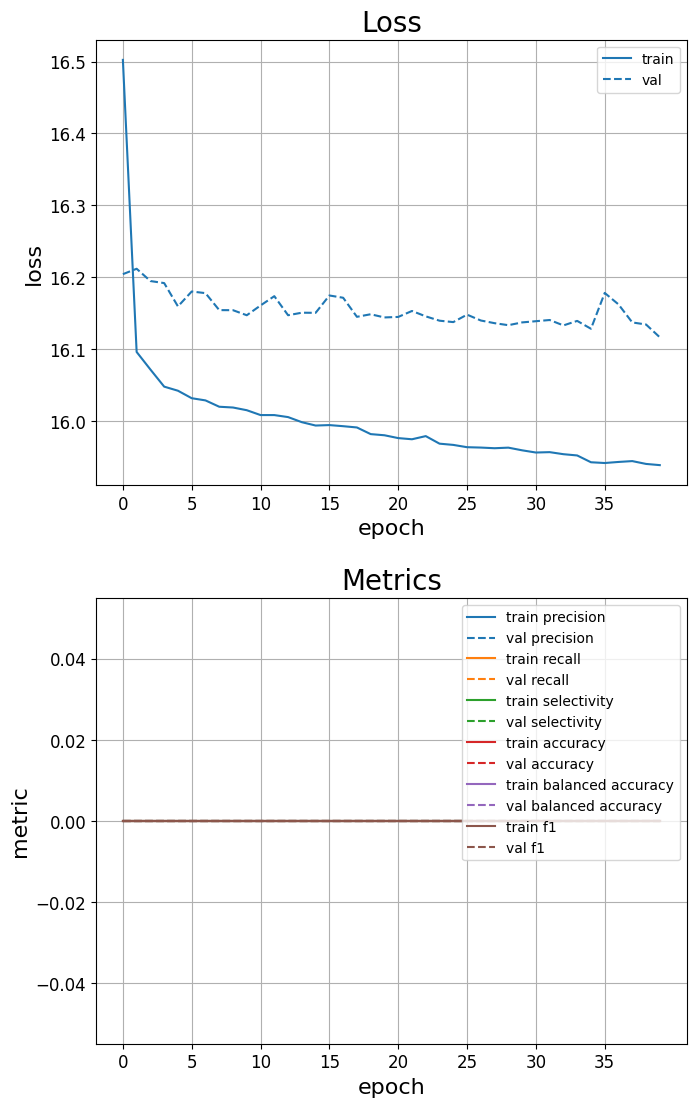

In [4]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(2, 1, figsize=(8, 12))
fig.tight_layout(pad=6.0)

epochs = np.arange(len(metrics['train_loss']))

for mode, fmt in zip(['train', 'val'], ['-', '--']):
    metric = metrics[f'{mode}_loss']
    if len(metric) > 0:
        ax[0].plot(epochs, metric, label=mode, linestyle=fmt, c='tab:blue')

for metr, col in zip(['precision', 'recall', 'selectivity', 'accuracy', 'balanced_accuracy', 'f1'],
                        ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']):
    for mode, fmt in zip(['train', 'val'], ['-', '--']):
        metric = metrics[f'{mode}_{metr}']
        if len(metric) > 0:
            ax[1].plot(epochs, metric, label=mode + ' ' + metr.replace('_', ' '), linestyle=fmt, c=col)

labels = ['loss', 'metric']
titles = ['Loss', 'Metrics']
legend_fontsize = [10, 10]

for i in range(2):
    ax[i].set_xticks(epochs[::5])
    ax[i].set_xlabel('epoch', fontsize=16)
    ax[i].set_ylabel(labels[i], fontsize=16)
    ax[i].set_title(titles[i], fontsize=20)
    ax[i].tick_params(labelsize=12)
    ax[i].grid(True)
    ax[i].legend(fontsize=legend_fontsize[i])
# if loss_ylim is not None:
#     ax[0].set_ylim(loss_ylim)
# if metric_ylim is not None:
#     ax[1].set_ylim(metric_ylim)

# plt.savefig(os.path.join(save_dir, 'metrics.png'))
plt.show()